# Data/fast MC comparison

- For now, compare SiPM values, but may need to look also at energy

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy  as np
import tables as tb

from   matplotlib.patches                      import Ellipse
from   matplotlib.font_manager                 import FontProperties
from   mpl_toolkits.mplot3d                    import Axes3D

In [2]:
xdim = 48
ydim = 48
zdim = 48

CAL_FACTOR = 1/255.
EMC_CUT = 1500
ESLICE_LOW = 15.

In [3]:
# plot a 20x20 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def NEW_SiPM_map_plot(xarr, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)
    ax1.axis([0, 500, 0, 500]);
    
    jet = plt.get_cmap('jet') 
    cNorm  = colors.LogNorm(vmin=0.0001, vmax=np.max(probs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

    for i in range(xdim):
        for j in range(ydim):
            r = Ellipse(xy=(i * 10 + 5, j * 10 + 5), width=5., height=5.);
            r.set_facecolor(scalarMap.to_rgba(probs[i,j]));
            #r.set_facecolor('0');
            #r.set_alpha(probs[i, j]);
            ax1.add_artist(r);
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");
    print("Max SiPM value is {}".format(np.max(xarr)))

## Read data

In [4]:
# define the function to read the data from multiple files
def read_data(loc, rname, f_start, f_end, fval, norm=False):
    """Reads all events from the files with the specified file numbers."""
    
    # read in the signal events.
    print("Reading signal events...")
    for fn in range(f_start,f_end):
        s_dat = tb.open_file("{0}/{1}/vox_dnn_Xe_EPEM_7bar_descape_2x2x2_out_{2}.h5".format(loc,rname,fn), 'r')
        if(fn == f_start):
            s_array = np.array(s_dat.root.maps)
            s_energies = np.array(s_dat.root.energies)
            print("-- Reading file {0},".format(fn), end=' ')
        else:
            print("{0},".format(fn), end=' ')
            s_array = np.concatenate([s_array,np.array(s_dat.root.maps)])
            s_energies = np.concatenate([s_energies,np.array(s_dat.root.energies)])
    print("done.")

    # read in the background events.
    print("\nReading background events...")
    for fn in range(f_start,f_end):
        b_dat = tb.open_file("{0}/{1}/vox_dnn_Xe_SE_7bar_descape_2x2x2_out_{2}.h5".format(loc,rname,fn), 'r')
        if(fn == f_start):
            print("-- Reading file {0},".format(fn), end=' ')
            b_array = np.array(b_dat.root.maps)
            b_energies = np.array(b_dat.root.energies)
        else:
            print("{0},".format(fn), end=' ')
            b_array = np.concatenate([b_array,np.array(b_dat.root.maps)])
            b_energies = np.concatenate([b_energies,np.array(b_dat.root.energies)])
    print("done.")
    print("\nRead {0} signal events and {1} background events.".format(len(s_array),len(b_array)))
        
    # concatenate the datasets, splitting into training and validation sets
    print("Concatenating datasets...")
    nval = int(fval * (len(s_array) + len(b_array)))
    
    if(nval == 0):
        x_ = np.concatenate([s_array, b_array])
        y_ = np.concatenate([np.ones([len(s_array), 1]), np.zeros([len(b_array), 1])])
        e_ = np.concatenate([s_energies,b_energies])
        e_sum = np.sum(e_,axis=1)

        # reshape for training with TensorFlow        
        print("Reshaping projection...")
        x_ = np.reshape(x_, (len(x_), xdim, ydim, zdim, 1))
        print("Finished reading data: {0} training/test events".format(len(x_)))
        return x_[e_sum > EMC_CUT],y_[e_sum > EMC_CUT],e_[e_sum > EMC_CUT]
    else:
        x_ = np.concatenate([s_array[0:-nval], b_array[0:-nval]])
        y_ = np.concatenate([np.ones([len(s_array[0:-nval]), 1]), np.zeros([len(b_array[0:-nval]), 1])])
        xval_ = np.concatenate([s_array[-nval:], b_array[-nval:]])
        yval_ = np.concatenate([np.ones([len(s_array[-nval:]), 1]), np.zeros([len(b_array[-nval:]), 1])])

        # reshape for training with TensorFlow
        print("Reshaping projection...")
        x_ = np.reshape(x_, (len(x_), xdim, ydim, zdim, 1))
        xval_ = np.reshape(xval_, (len(xval_), xdim, ydim, zdim, 1))
        print("Finished reading data: {0} training/test and {1} validation events".format(len(x_),len(xval_)))
        
        if(norm):
            mval = np.mean(x_)
            sigval = np.std(x_)
            x_ -= mval
            x_ /= sigval

            mval = np.mean(xval_)
            sigval = np.std(xval_)
            xval_ -= mval
            xval_ /= sigval
        
        
        return x_,y_,xval_,yval_

In [5]:
# define the function to read the data from multiple files
def read_real_data(fname, norm=False):
    """Reads data from the specified file."""
    
    # read in the signal events.
    print("Reading real data...")
    f_dat = tb.open_file(fname, 'r')
    f_array = np.array(f_dat.root.maps)
    f_evts = np.array(f_dat.root.evtnum)
    f_en = np.array(f_dat.root.energy)
    print("done.")

    # reshape for training with TensorFlow        
    print("Reshaping...")
    x_ = np.reshape(f_array, (len(f_array), 48, 48, 48, 1))
    
    mval = np.mean(x_)
    sigval = np.std(x_)
    
    if(norm):
        x_ -= mval
        x_ /= sigval
    
    print("Finished reading data: {0} events".format(len(x_)))
    return x_,f_evts,f_en

In [6]:
# merge in slices at the end of the event with very low energy
def merge_low_energy(xarr,earr,CFAC):
    
    xmerge = []
    emerge = []
    for xv,ev in zip(xarr,earr):
        nze = np.nonzero(ev)[0]
        if((ev[-1]*CFAC < ESLICE_LOW) and len(nze) > 1):
            ilast = nze[-1]
            islast = nze[-2]
            #print("Merging slice of energy {} into slice of energy {}".format(ev[ilast],ev[islast]))
            ev[islast] += ev[ilast]
            xv[:,:,islast] += xv[:,:,ilast]
            ev[ilast] = 0.
            xv[:,:,ilast] = 0.
        xmerge.append(xv)
        emerge.append(ev)
    
    xmerge = np.array(xmerge)
    emerge = np.array(emerge)
    
    return xmerge,emerge

## Read in the data and MC

In [18]:
x_MC, y_MC, e_MC = read_data("/data/fastmc/descape", "voxels", 0, 50, 0.0)
x_MC, e_MC = merge_low_energy(x_MC,e_MC,1.)
x_MC_si = x_MC[0:450]
e_MC_si = e_MC[0:450]
x_MC_bg = x_MC[int(len(x_MC)/2):int(len(x_MC)/2) + 450]
e_MC_bg = e_MC[int(len(x_MC)/2):int(len(x_MC)/2) + 450]
x_data, evt_data, e_data = read_real_data("/data/fastmc/descape/classification/data_4735_nonorm_nocenter_E.h5")
x_data, e_data = merge_low_energy(x_data,e_data,CAL_FACTOR)
x_data = x_data[0:450]
e_data = e_data[0:450]

Reading signal events...
-- Reading file 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, done.

Reading background events...
-- Reading file 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, done.

Read 497 signal events and 500 background events.
Concatenating datasets...
Reshaping projection...
Finished reading data: 997 training/test events
Reading real data...
done.
Reshaping...
Finished reading data: 982 events


## Plots of the SiPM plane

/home/jrenner/miniconda/envs/IC3.6/lib/python3.6/site-packages/matplotlib/colors.py:469: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


Max SiPM value is 577.733154296875
Overall active SiPMs: 1784


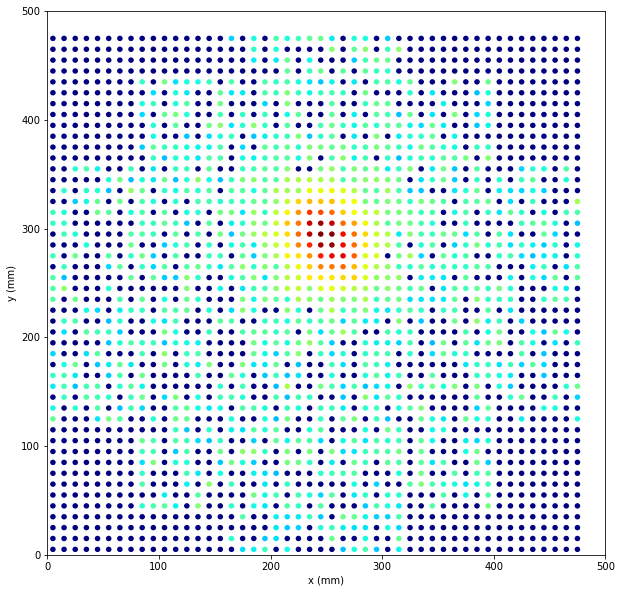

In [19]:
#NEW_SiPM_map_plot(np.sum(x_data[:,:,:,:,0],axis=(0,3)))
NEW_SiPM_map_plot(x_MC_si[400,:,:,1,0])
print("Overall active SiPMs: {}".format(len(np.nonzero(np.sum(x_data[:,:,:,:,0],axis=(0,3)))[0])))
#zsipms = np.sum(x_data[:,:,:,:,0],axis=(0,3)).flatten()
#zsipms = np.where(zsipms == 0)[0]
#np.savez("omit_sipms.npz",zsipms=zsipms)

In [20]:
print(x_MC_si.shape)
print(np.argmax(x_MC_si)/48/48/48)
print(np.max(x_MC_si[370,:,:,9,0]))
print(e_MC_si[370])

(450, 48, 48, 48, 1)
331.428032769
0.0
[  74.02420807  167.91679382  513.4130249   190.14710999  647.03717041
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.        ]


In [21]:
xarr = x_MC_si[1,:,:,0,0].flatten()
len(xarr[(xarr > 0) & (xarr < 10)])
#print(xarr[(xarr > 0) & (xarr < 30)])

919

Number of active SiPMs: 922


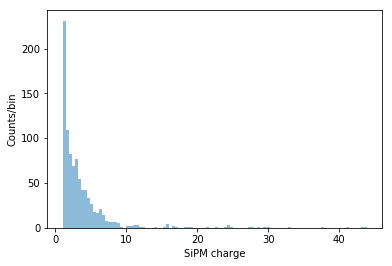

In [22]:
nbins = 100

fig = plt.figure(1)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

svals = x_data[1,:,:,0,0].flatten()
plt.hist(svals[(svals > 0) & (svals < 50)],bins=nbins,alpha=0.5,label='MC signal')
plt.xlabel('SiPM charge')
plt.ylabel('Counts/bin')
print("Number of active SiPMs: {}".format(len(svals[svals > 0])))

## Array preparation

In [23]:
def prepare_arrays(x_arr,e_arr,CFAC=1.):
    
    # Number of slices and SiPM max
    sipm_max_perslice = []
    nslices = []
    amax = np.amax(x_arr[:,:,:,:,0],axis=(1,2))
    for sl in amax:
        nslices.append(len(np.nonzero(sl)[0]))
        for aa in sl:
            if(aa > 0):
                sipm_max_perslice.append(aa)
                
    # Number of active SiPMs in a slice.
    nactive_sipms = []
    for xv in x_arr:
        for nz in range(xv.shape[2]):
            nactive = len(np.nonzero(xv[:,:,nz,0])[0])
            if(nactive > 0):
                nactive_sipms.append(nactive)
                
    # SiPM values
    sipms = []
    for xv,ev in zip(x_arr,e_arr):
        if(np.max(ev)*CFAC < 750):
            xflat = xv.flatten()
            sipms.extend(xflat[xflat > 0])
        
    # Energy values
    energies = e_arr.flatten()
    energies = energies[energies > 0.]
    
    # Event energies
    eevt = np.sum(e_arr,axis=1)
    
    sipm_max_perslice = np.array(sipm_max_perslice)
    nslices = np.array(nslices)
    nactive_sipms = np.array(nactive_sipms)
    sipms = np.array(sipms)
    energies = np.array(energies)
    eevt = np.array(eevt)
        
    return sipm_max_perslice, nslices, nactive_sipms, sipms, energies, eevt

In [24]:
print("Preparing MC signal arrays...")
MCsi_sipm_max_perslice, MCsi_nslices, MCsi_nactive_sipms, MCsi_sipms, MCsi_energies, MCsi_eevt = prepare_arrays(x_MC_si, e_MC_si)
print("Preparing MC background arrays...")
MCbg_sipm_max_perslice, MCbg_nslices, MCbg_nactive_sipms, MCbg_sipms, MCbg_energies, MCbg_eevt = prepare_arrays(x_MC_bg, e_MC_bg)
print("Preparing data arrays...")
data_sipm_max_perslice, data_nslices, data_nactive_sipms, data_sipms, data_energies, data_eevt = prepare_arrays(x_data, e_data, CAL_FACTOR)

Preparing MC signal arrays...
Preparing MC background arrays...
Preparing data arrays...


## Maximum SiPM charge

3037
3419


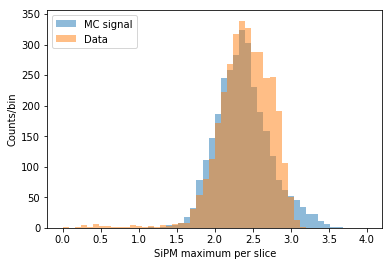

In [30]:
nbins = 50
rng_min = 0.0
rng_max = 4.0

fig = plt.figure(1)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

plt.hist(np.log10(MCsi_sipm_max_perslice),bins=nbins,alpha=0.5,label='MC signal',range=(rng_min,rng_max))
#plt.hist(np.log10(MCbg_sipm_max_perslice),bins=nbins,alpha=0.5,label='MC background',range=(rng_min,rng_max))
plt.hist(np.log10(data_sipm_max_perslice),bins=nbins,alpha=0.5,label='Data',range=(rng_min,rng_max))
plt.legend(loc=2)
plt.xlabel('SiPM maximum per slice')
plt.ylabel('Counts/bin')
#plt.xscale('log')
#plt.savefig("fig/MCvDAT_SiPM_max_per_slice.pdf", bbox_inches='tight')
print(len(MCsi_sipm_max_perslice))
print(len(data_sipm_max_perslice))

## Number of slices

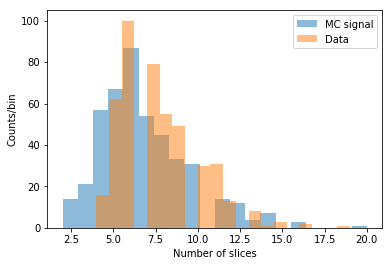

In [26]:
nbins = 20

fig = plt.figure(1)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

plt.hist(MCsi_nslices,bins=nbins,alpha=0.5,label='MC signal')
#plt.hist(MCbg_nslices,bins=nbins,alpha=0.5,label='MC background')
plt.hist(data_nslices,bins=nbins,alpha=0.5,label='Data')
plt.legend(loc=1)
plt.xlabel('Number of slices')
plt.ylabel('Counts/bin')
#plt.xscale('log')
#plt.savefig("fig/MCvDAT_nslices.pdf", bbox_inches='tight')

## Number of active SiPMs

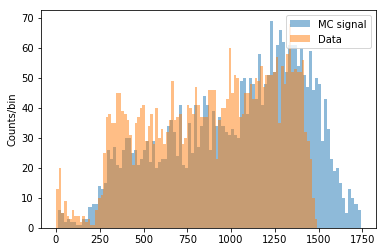

In [31]:
nbins = 100

fig = plt.figure(1)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

plt.hist(MCsi_nactive_sipms,bins=nbins,alpha=0.5,label='MC signal')
#plt.hist(MCbg_nactive_sipms,bins=nbins,alpha=0.5,label='MC background')
plt.hist(data_nactive_sipms,bins=nbins,alpha=0.5,label='Data')
plt.legend(loc=1)
plt.xlabel('')
plt.ylabel('Counts/bin')
#plt.xscale('log')
#plt.savefig("fig/MCvDAT_nactive_sipms.pdf", bbox_inches='tight')

## SiPM values

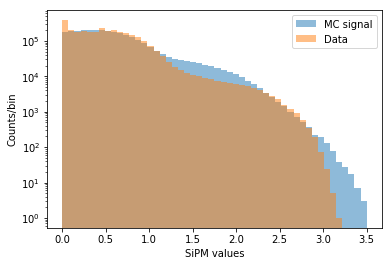

In [28]:
nbins = 50
rng_min = 0.0
rng_max = 3.5

fig = plt.figure(1)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

plt.hist(np.log10(MCsi_sipms),bins=nbins,alpha=0.5,label='MC signal',range=(rng_min,rng_max))
#plt.hist(np.log(MCbg_sipms),bins=nbins,alpha=0.5,label='MC background',range=(rng_min,rng_max))
plt.hist(np.log10(data_sipms),bins=nbins,alpha=0.5,label='Data',range=(rng_min,rng_max))
plt.legend(loc=1)
plt.xlabel('SiPM values')
plt.ylabel('Counts/bin')
plt.yscale('log')
#plt.savefig("fig/MCvDAT_SiPMs.pdf", bbox_inches='tight')

## Energies

In [ ]:
nbins = 40
rng_start = 0
rng_end = 2000

fig = plt.figure(1)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

plt.hist(MCsi_energies,bins=nbins,alpha=0.5,label='MC signal',range=[rng_start,rng_end])
#plt.hist(MCbg_energies,bins=nbins,alpha=0.5,label='MC background',range=[rng_start,rng_end])
plt.hist(data_energies*CAL_FACTOR,bins=nbins,alpha=0.5,label='Data',range=[rng_start,rng_end])
plt.legend(loc=1)
plt.xlabel('Energy values')
plt.ylabel('Counts/bin')
plt.yscale('log')
#plt.savefig("fig/MCvDAT_SiPMs.pdf", bbox_inches='tight')

In [ ]:
len(data_energies)

## Energy calibration

In [ ]:
nbins = 20

fig = plt.figure(1)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

plt.hist(MCsi_eevt,bins=nbins,alpha=0.5,label='MC signal')
plt.hist(MCbg_eevt,bins=nbins,alpha=0.5,label='MC background')
plt.hist(data_eevt*CAL_FACTOR,bins=nbins,alpha=0.5,label='Data')
plt.legend(loc=1)
plt.xlabel('Energy values')
plt.ylabel('Counts/bin')
plt.yscale('log')

In [ ]:
#print(np.sum(e_MC_bg,axis=1))

## Radial response

In [ ]:
# Number of time bins
n_tbins = 2

# Coefficients from S2 parameterization
M = [1.599, 1.599]
c0 = [7.72708346764e-05, 0.000116782596518]
c1 = [-1.69330613273e-07, 3.05115354927e-06]
c2 = [-1.52173658255e-06, -7.00800605142e-06]
c3 = [-2.4985972302e-07, 6.53907883449e-07]
c4 = [1.12327204397e-07, 8.95230202525e-08]
c5 = [-1.49353264606e-08, -2.27173290582e-08]
c6 = [1.04614146487e-09, 2.00740799864e-09]
c7 = [-4.19111362353e-11, -9.21915945523e-11]
c8 = [9.12129133361e-13, 2.20534216312e-12]
c9 = [-8.40089561697e-15, -2.1795164563e-14]

# Maximum radial extent of parameterization
rmax = 20.

# Return the SiPM response for the specified time bin and radial distance.
def sipm_par(tbin,r):

    # Ensure the time bin value is valid.
    if(tbin < 0 or tbin >= n_tbins):
        print("Invalid time bin in sipm_param: returning 0.0 ...")
        return 0.0

    # Calculate the response based on the parametrization.
    vpar = M[tbin]*(c0[tbin] + c1[tbin]*r + c2[tbin]*r**2 + c3[tbin]*r**3 +
    c4[tbin]*r**4 + c5[tbin]*r**5 + c6[tbin]*r**6 + c7[tbin]*r**7 +
    c8[tbin]*r**8 + c9[tbin]*r**9)

    # Zero the response for radii too large.
    if(hasattr(vpar, "__len__")):
        ret = np.zeros(len(vpar)); iret = 0
        for rv,pv in zip(r,vpar):
            if(rv < rmax):
                ret[iret] = pv
            iret += 1
        return ret
    else:
        if(r < rmax):
            return vpar
        return 0.0


E_to_Q = 1.2e3
def sipm_lcone(r,A,d,ze):
    v = (A/(4*np.pi*d*np.sqrt(r**2 + ze**2)))*(1 - np.sqrt((r**2 + ze**2)/(r**2 + (ze+d)**2)))
    return v

def sipm_lcone2(r,A,d,ze):
    v = (A/(4*np.pi*d*np.sqrt(r**2 + ze**2)))*(1 - np.sqrt((r**2 + ze**2)/(r**2 + (ze+d)**2)))
    return v

In [ ]:
rr = np.arange(0,30.,0.01)
A = 1.
d = 5.0
ze = 5.0
resp1 = sipm_lcone2(rr,A,d,ze)*E_to_Q*10.0
resp2 = sipm_lcone(rr,1.,6.,4.)*E_to_Q*3.0
#resp3 = 0.5*(sipm_par(0,rr) + sipm_par(1,rr))*E_to_Q*38
plt.plot(rr,resp1,label='r1')
plt.plot(rr,resp2,label='r2')
plt.legend(loc=1)